# RAG Evaluation: Semantic vs Keyword vs Hybrid Search

This notebook evaluates three different search approaches:
1. **Semantic Search** (FAISS vector search) - `/search`
2. **Keyword Search** (FTS5 full-text search) - `/keyword_search`  
3. **Hybrid Search** (RRF fusion of semantic + keyword) - `/hybrid_search`

**Evaluation Metric**: Hit Rate@3 (percentage of queries where at least one relevant document appears in top-3 results)

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Set
import time

## Configuration and API Client Setup

In [2]:
# API Configuration
API_BASE = "http://127.0.0.1:8000"
K = 3  # Top-k results to evaluate

def call_semantic_search(query: str, k: int = K) -> List[Dict]:
    """Call /search endpoint for semantic search"""
    response = requests.post(f"{API_BASE}/search", json={
        "query": query,
        "k": k,
        "min_score": 0.1
    })
    if response.status_code == 200:
        return response.json()["hits"]
    else:
        print(f"Semantic search failed: {response.text}")
        return []

def call_keyword_search(query: str, k: int = K) -> List[Dict]:
    """Call /keyword_search endpoint for FTS5 search"""
    response = requests.post(f"{API_BASE}/keyword_search", json={
        "query": query,
        "k": k,
        "min_score": 0.01
    })
    if response.status_code == 200:
        return response.json()["hits"]
    else:
        print(f"Keyword search failed: {response.text}")
        return []

def call_hybrid_search(query: str, k: int = K) -> List[Dict]:
    """Call /hybrid_search endpoint for RRF fusion"""
    response = requests.post(f"{API_BASE}/hybrid_search", json={
        "query": query,
        "k": k,
        "semantic_k": 15,
        "keyword_k": 15,
        "rrf_constant": 60,
        "min_score": 0.1
    })
    if response.status_code == 200:
        return response.json()["hits"]
    else:
        print(f"Hybrid search failed: {response.text}")
        return []

# Test API connectivity
try:
    health = requests.get(f"{API_BASE}/healthz")
    print(f"API Status: {health.json()}")
except Exception as e:
    print(f"⚠️  API not available: {e}")
    print("Please start the search API with: python search_api.py")

API Status: {'ok': True, 'vectors': 3991, 'device': 'cuda'}


## Test Queries and Expected Relevant Keywords

Each query is paired with keywords that should appear in relevant documents. This allows us to automatically assess relevance.

In [3]:
# Test queries with expected relevant terms for automatic evaluation
TEST_QUERIES = [
    {
        "query": "neural network architecture design",
        "relevant_terms": ["neural", "network", "architecture", "layer", "deep learning"],
        "description": "General neural network concepts"
    },
    {
        "query": "transformer attention mechanism",
        "relevant_terms": ["transformer", "attention", "self-attention", "query", "key", "value"],
        "description": "Transformer architecture details"
    },
    {
        "query": "convolutional neural network CNN",
        "relevant_terms": ["convolutional", "CNN", "convolution", "filter", "kernel"],
        "description": "CNN-specific terminology"
    },
    {
        "query": "natural language processing NLP",
        "relevant_terms": ["natural language", "NLP", "text", "language model", "tokenization"],
        "description": "NLP domain concepts"
    },
    {
        "query": "machine learning optimization",
        "relevant_terms": ["machine learning", "optimization", "gradient", "training", "learning rate"],
        "description": "ML optimization techniques"
    },
    {
        "query": "computer vision image classification",
        "relevant_terms": ["computer vision", "image", "classification", "vision", "visual"],
        "description": "Computer vision tasks"
    },
    {
        "query": "reinforcement learning RL agent",
        "relevant_terms": ["reinforcement", "RL", "agent", "reward", "policy"],
        "description": "Reinforcement learning concepts"
    },
    {
        "query": "large language model LLM",
        "relevant_terms": ["large language", "LLM", "language model", "pre-trained", "GPT"],
        "description": "Large language models"
    },
    {
        "query": "deep learning backpropagation",
        "relevant_terms": ["deep learning", "backpropagation", "gradient", "forward pass", "backward pass"],
        "description": "Deep learning fundamentals"
    },
    {
        "query": "generative adversarial network GAN",
        "relevant_terms": ["generative", "adversarial", "GAN", "generator", "discriminator"],
        "description": "GAN architecture"
    },
    {
        "query": "support vector machine SVM",
        "relevant_terms": ["support vector", "SVM", "kernel", "margin", "classification"],
        "description": "Traditional ML algorithm"
    },
    {
        "query": "recurrent neural network RNN LSTM",
        "relevant_terms": ["recurrent", "RNN", "LSTM", "sequence", "memory"],
        "description": "Sequential models"
    }
]

print(f"Created {len(TEST_QUERIES)} test queries")
for i, q in enumerate(TEST_QUERIES, 1):
    print(f"{i:2d}. {q['query']} - {q['description']}")

Created 12 test queries
 1. neural network architecture design - General neural network concepts
 2. transformer attention mechanism - Transformer architecture details
 3. convolutional neural network CNN - CNN-specific terminology
 4. natural language processing NLP - NLP domain concepts
 5. machine learning optimization - ML optimization techniques
 6. computer vision image classification - Computer vision tasks
 7. reinforcement learning RL agent - Reinforcement learning concepts
 8. large language model LLM - Large language models
 9. deep learning backpropagation - Deep learning fundamentals
10. generative adversarial network GAN - GAN architecture
11. support vector machine SVM - Traditional ML algorithm
12. recurrent neural network RNN LSTM - Sequential models


## Relevance Assessment Function

We assess relevance by checking if the document text contains any of the expected relevant terms.

In [4]:
def assess_relevance(hit: Dict, relevant_terms: List[str]) -> bool:
    """
    Assess if a search hit is relevant based on presence of relevant terms.
    Returns True if any relevant term is found in title or text (case-insensitive).
    """
    # Combine title and text for relevance checking
    content = ""
    if hit.get("title"):
        content += hit["title"].lower() + " "
    if hit.get("text"):
        content += hit["text"].lower()
    
    # Check if any relevant term appears in content
    for term in relevant_terms:
        if term.lower() in content:
            return True
    return False

def calculate_hit_rate_at_k(hits: List[Dict], relevant_terms: List[str], k: int = 3) -> bool:
    """
    Calculate if there's a hit in top-k results.
    Returns True if at least one of the top-k results is relevant.
    """
    for hit in hits[:k]:
        if assess_relevance(hit, relevant_terms):
            return True
    return False

# Test the relevance assessment
test_hit = {
    "title": "Neural Network Architecture Design",
    "text": "This paper presents a novel approach to designing deep neural networks..."
}
test_terms = ["neural", "network", "architecture"]
print(f"Test relevance assessment: {assess_relevance(test_hit, test_terms)}")

Test relevance assessment: True


## Run Evaluation Experiment

In [5]:
def run_evaluation():
    """Run evaluation experiment across all test queries and search methods"""
    results = []
    
    print("Running evaluation experiment...")
    print(f"Evaluating {len(TEST_QUERIES)} queries with Hit Rate@{K}\n")
    
    for i, test_case in enumerate(TEST_QUERIES, 1):
        query = test_case["query"]
        relevant_terms = test_case["relevant_terms"]
        description = test_case["description"]
        
        print(f"Query {i:2d}: {query}")
        print(f"         {description}")
        
        # Call all three search methods
        semantic_hits = call_semantic_search(query)
        keyword_hits = call_keyword_search(query)
        hybrid_hits = call_hybrid_search(query)
        
        # Calculate hit rates
        semantic_hit = calculate_hit_rate_at_k(semantic_hits, relevant_terms, K)
        keyword_hit = calculate_hit_rate_at_k(keyword_hits, relevant_terms, K)
        hybrid_hit = calculate_hit_rate_at_k(hybrid_hits, relevant_terms, K)
        
        # Store results
        result = {
            "query_id": i,
            "query": query,
            "description": description,
            "semantic_hit": semantic_hit,
            "keyword_hit": keyword_hit,
            "hybrid_hit": hybrid_hit,
            "semantic_count": len(semantic_hits),
            "keyword_count": len(keyword_hits),
            "hybrid_count": len(hybrid_hits)
        }
        results.append(result)
        
        # Print results for this query
        print(f"         Semantic: {'✓' if semantic_hit else '✗'} ({len(semantic_hits)} results)")
        print(f"         Keyword:  {'✓' if keyword_hit else '✗'} ({len(keyword_hits)} results)")
        print(f"         Hybrid:   {'✓' if hybrid_hit else '✗'} ({len(hybrid_hits)} results)")
        print()
        
        # Brief pause to be nice to the API
        time.sleep(0.1)
    
    return results

# Run the evaluation
evaluation_results = run_evaluation()

Running evaluation experiment...
Evaluating 12 queries with Hit Rate@3

Query  1: neural network architecture design
         General neural network concepts
         Semantic: ✓ (3 results)
         Keyword:  ✗ (0 results)
         Hybrid:   ✓ (3 results)

Query  2: transformer attention mechanism
         Transformer architecture details
         Semantic: ✓ (3 results)
         Keyword:  ✓ (1 results)
         Hybrid:   ✓ (3 results)

Query  3: convolutional neural network CNN
         CNN-specific terminology
         Semantic: ✓ (3 results)
         Keyword:  ✗ (0 results)
         Hybrid:   ✓ (3 results)

Query  4: natural language processing NLP
         NLP domain concepts
         Semantic: ✓ (3 results)
         Keyword:  ✓ (3 results)
         Hybrid:   ✓ (3 results)

Query  5: machine learning optimization
         ML optimization techniques
         Semantic: ✓ (3 results)
         Keyword:  ✓ (3 results)
         Hybrid:   ✓ (3 results)

Query  6: computer vision image cl

## Results Analysis and Metrics

In [6]:
# Convert results to DataFrame for analysis
df = pd.DataFrame(evaluation_results)

# Calculate overall hit rates
semantic_hit_rate = df['semantic_hit'].mean()
keyword_hit_rate = df['keyword_hit'].mean()
hybrid_hit_rate = df['hybrid_hit'].mean()

print(f"📊 EVALUATION RESULTS - Hit Rate@{K}")
print("=" * 40)
print(f"Semantic Search:  {semantic_hit_rate:.3f} ({semantic_hit_rate*100:.1f}%)")
print(f"Keyword Search:   {keyword_hit_rate:.3f} ({keyword_hit_rate*100:.1f}%)")
print(f"Hybrid Search:    {hybrid_hit_rate:.3f} ({hybrid_hit_rate*100:.1f}%)")
print("=" * 40)

# Calculate performance improvements
hybrid_vs_semantic = ((hybrid_hit_rate - semantic_hit_rate) / semantic_hit_rate) * 100 if semantic_hit_rate > 0 else 0
hybrid_vs_keyword = ((hybrid_hit_rate - keyword_hit_rate) / keyword_hit_rate) * 100 if keyword_hit_rate > 0 else 0

print(f"\n📈 PERFORMANCE IMPROVEMENTS")
print(f"Hybrid vs Semantic: {hybrid_vs_semantic:+.1f}%")
print(f"Hybrid vs Keyword:  {hybrid_vs_keyword:+.1f}%")

# Show detailed results table
print(f"\n📋 DETAILED RESULTS")
display_df = df[['query_id', 'query', 'semantic_hit', 'keyword_hit', 'hybrid_hit']].copy()
display_df.columns = ['ID', 'Query', 'Semantic', 'Keyword', 'Hybrid']
print(display_df.to_string(index=False))

📊 EVALUATION RESULTS - Hit Rate@3
Semantic Search:  1.000 (100.0%)
Keyword Search:   0.500 (50.0%)
Hybrid Search:    1.000 (100.0%)

📈 PERFORMANCE IMPROVEMENTS
Hybrid vs Semantic: +0.0%
Hybrid vs Keyword:  +100.0%

📋 DETAILED RESULTS
 ID                                Query  Semantic  Keyword  Hybrid
  1   neural network architecture design      True    False    True
  2      transformer attention mechanism      True     True    True
  3     convolutional neural network CNN      True    False    True
  4      natural language processing NLP      True     True    True
  5        machine learning optimization      True     True    True
  6 computer vision image classification      True     True    True
  7      reinforcement learning RL agent      True    False    True
  8             large language model LLM      True     True    True
  9        deep learning backpropagation      True    False    True
 10   generative adversarial network GAN      True    False    True
 11           supp

## Visualization of Results

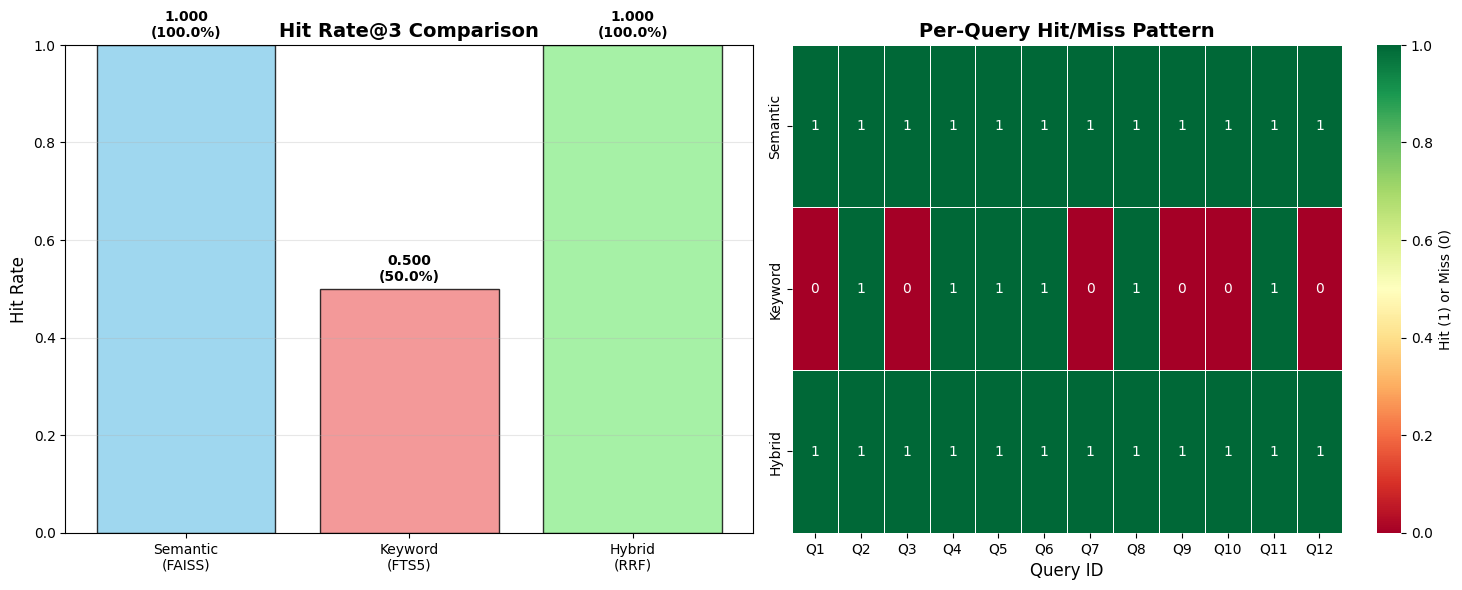


📊 SUMMARY STATISTICS
Total queries evaluated: 12
Semantic hits: 12/12
Keyword hits:  6/12
Hybrid hits:   12/12


In [7]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of overall hit rates
methods = ['Semantic\n(FAISS)', 'Keyword\n(FTS5)', 'Hybrid\n(RRF)']
hit_rates = [semantic_hit_rate, keyword_hit_rate, hybrid_hit_rate]
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = ax1.bar(methods, hit_rates, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title(f'Hit Rate@{K} Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Hit Rate', fontsize=12)
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, hit_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.3f}\n({rate*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

# Heatmap of per-query results
query_results = df[['semantic_hit', 'keyword_hit', 'hybrid_hit']].T
query_results.columns = [f'Q{i}' for i in range(1, len(TEST_QUERIES)+1)]
query_results.index = ['Semantic', 'Keyword', 'Hybrid']

sns.heatmap(query_results, annot=True, cmap='RdYlGn', center=0.5, 
            cbar_kws={'label': 'Hit (1) or Miss (0)'}, ax=ax2,
            linewidths=0.5, linecolor='white')
ax2.set_title('Per-Query Hit/Miss Pattern', fontsize=14, fontweight='bold')
ax2.set_xlabel('Query ID', fontsize=12)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 SUMMARY STATISTICS")
print(f"Total queries evaluated: {len(TEST_QUERIES)}")
print(f"Semantic hits: {df['semantic_hit'].sum()}/{len(TEST_QUERIES)}")
print(f"Keyword hits:  {df['keyword_hit'].sum()}/{len(TEST_QUERIES)}")
print(f"Hybrid hits:   {df['hybrid_hit'].sum()}/{len(TEST_QUERIES)}")

## Example Query Analysis

Let's examine a few specific queries in detail to understand how different methods perform.

In [8]:
def analyze_query_details(query_text: str, relevant_terms: List[str]):
    """Analyze a specific query in detail"""
    print(f"🔍 DETAILED ANALYSIS: '{query_text}'")
    print(f"Expected terms: {', '.join(relevant_terms)}")
    print("=" * 60)
    
    # Get results from all methods
    semantic_hits = call_semantic_search(query_text, k=5)
    keyword_hits = call_keyword_search(query_text, k=5)
    hybrid_hits = call_hybrid_search(query_text, k=5)
    
    methods = [
        ("Semantic (FAISS)", semantic_hits),
        ("Keyword (FTS5)", keyword_hits),
        ("Hybrid (RRF)", hybrid_hits)
    ]
    
    for method_name, hits in methods:
        print(f"\n{method_name}:")
        if not hits:
            print("  No results returned")
            continue
            
        for i, hit in enumerate(hits[:3], 1):
            relevant = assess_relevance(hit, relevant_terms)
            relevance_indicator = "✓" if relevant else "✗"
            
            print(f"  {i}. [{relevance_indicator}] Score: {hit['score']:.4f}")
            print(f"      Doc: {hit.get('doc_id', 'N/A')}")
            print(f"      Title: {hit.get('title', 'N/A')[:80]}...")
            if hit.get('text'):
                preview = hit['text'][:120].replace('\n', ' ')
                print(f"      Text: {preview}...")
            print()

# Analyze a few example queries
example_queries = [
    ("transformer attention mechanism", ["transformer", "attention", "self-attention"]),
    ("machine learning optimization", ["machine learning", "optimization", "gradient"]),
    ("neural network architecture design", ["neural", "network", "architecture"])
]

for query, terms in example_queries[:2]:  # Analyze first 2 to save space
    analyze_query_details(query, terms)
    print("\n" + "="*80 + "\n")

🔍 DETAILED ANALYSIS: 'transformer attention mechanism'
Expected terms: transformer, attention, self-attention

Semantic (FAISS):
  1. [✓] Score: 0.5459
      Doc: 2508.11388v1
      Title: Model Interpretability and Rationale Extraction by Input Mask Optimization...
      Text: - guistics. shiyu chang, yang zhang, mo yu, and tommi jaakkola. 2019. a game theoretic approach to class - wise se - lec...

  2. [✓] Score: 0.4918
      Doc: 2508.11388v1
      Title: Model Interpretability and Rationale Extraction by Input Mask Optimization...
      Text: input marc m - perturb raw attention rollout attribution tam marc vis. saliency inputxgrad integr. grads occlusion grad ...

  3. [✓] Score: 0.4778
      Doc: 2508.11166v1
      Title: Overcoming Low-Resource Barriers in Tulu: Neural Models and Corpus Creation for ...
      Text: 3. 1 comparative evaluation with transformer - based models transformer baselines such as mbert and xlm - roberta provid...


Keyword (FTS5):
  1. [✓] Score: 11.1494